In [146]:
import pyvista as pv
from linetimer import CodeTimer
from skimage.measure import label, regionprops, regionprops_table
%matplotlib inline

In [5]:

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from BabelViscoFDTD.tools.RayleighAndBHTE import GenerateFocusTx,SpeedofSoundWater, GenerateSurface,InitMetal,ForwardSimple,InitOpenCL
from BabelViscoFDTD.H5pySimple import SaveToH5py,ReadFromH5py
from BabelIntegrationBASE import Material
from BabelViscoFDTD.PropagationModel import PropagationModel

PModel=PropagationModel()

InitMetal('M3')
import os


extlay={}
TemperatureWater=37.0
extlay['c']=SpeedofSoundWater(TemperatureWater)



def computeExaNeuroGeometry():
    # transxyz = np.loadtxt(os.path.join(os.path.dirname(os.path.realpath(__file__)),'ExaNeuroTransducerGeometry.csv'),delimiter=',',skiprows=0)
    transxyz = np.loadtxt(os.path.join('.','ExaNeuroTransducerGeometry.csv'),delimiter=',',skiprows=0)
    assert(transxyz.shape[0]==1024) #number of elements
    assert(transxyz.shape[1]==4) #element, X,Y,Z coordinates in mm, and area in mm2
    transxyz=transxyz[:,:3] #we skip the Tx element coordinates only
    return transxyz*1e-3

DimensionElem = np.sqrt(113.54)*1e-3
DimensionElem = 10e-3

def GenerateExaNeuroTx(Frequency=220e3,RotationZ=0,FactorEnlarge=1,PPWSurface=9):

    f=Frequency;
    Foc=150e-3*FactorEnlarge
    Diameter=9e-3*FactorEnlarge

    #%This is the indiv tx element
    TxElem=GenerateFocusTx(f,Foc,Diameter,extlay['c'],PPWSurface=PPWSurface)

    transLoc = computeExaNeuroGeometry()
    # transLoc=transLoc[[0,1023],:]
  
    transLocDisplacedZ=transLoc.copy()
    transLocDisplacedZ[:,2]-=Foc
    # print(transLocDisplacedZ)
    NElems=transLoc.shape[0]
    nSubElems=len( TxElem['ds'])
   
    nSubElemsVert=TxElem['VertDisplay'].shape[0]
    # print('nSubElemsVert',nSubElemsVert)

    XYNorm=np.linalg.norm(transLocDisplacedZ[:,:2],axis=1)
    VN=np.linalg.norm(transLocDisplacedZ,axis=1)
    theta=np.arcsin(XYNorm/VN)
    phi=np.arctan2(transLocDisplacedZ[:,1],transLocDisplacedZ[:,0])
    phi+=np.deg2rad(RotationZ)
    # print('theta',theta)
    # print('phi',phi)

    TxExaNeuro={}
    TxExaNeuro['center'] = np.zeros((nSubElems*NElems,3))
    TxExaNeuro['elemcenter'] = np.zeros((len(theta),3))
    TxExaNeuro['ds'] = np.zeros((nSubElems*NElems,1))
    TxExaNeuro['normal'] = np.zeros((nSubElems*NElems,3))
    TxExaNeuro['elemdims']=TxElem['ds'].size
    TxExaNeuro['NumberElems']=len(theta)
    TxExaNeuro['VertDisplay'] = np.zeros((nSubElemsVert*NElems,3))
    TxExaNeuro['FaceDisplay'] = np.zeros((nSubElems*NElems,4),np.int64)

    for n in range(len(theta)):
        rotateMatrixY = np.array([[np.cos(theta[n]),0,np.sin(theta[n])],[0,1,0],[-np.sin(theta[n]),0,np.cos(theta[n])]])
        rotateMatrixZ = np.array([[-np.cos(phi[n]),np.sin(phi[n]),0],[-np.sin(phi[n]),-np.cos(phi[n]),0],[0,0,1]])
        rotateMatrix = rotateMatrixZ@rotateMatrixY
       
        center=(rotateMatrix@TxElem['center'].T).T
        TxExaNeuro['elemcenter'][n,:]=np.mean(center,axis=0) # the very first subelement is at the center
        
        normal=(rotateMatrix@TxElem['normal'].T).T

        VertDisplay=(rotateMatrix@TxElem['VertDisplay'].T).T
       
        TxExaNeuro['center'][n*nSubElems:(n+1)*nSubElems,:]=center
        TxExaNeuro['ds'][n*nSubElems:(n+1)*nSubElems]=TxElem['ds']
        TxExaNeuro['normal'][n*nSubElems:(n+1)*nSubElems,:]=normal
        TxExaNeuro['VertDisplay'][n*nSubElemsVert:(n+1)*nSubElemsVert,:]=VertDisplay
        TxExaNeuro['FaceDisplay'][n*nSubElems:(n+1)*nSubElems,:]=TxElem['FaceDisplay']+n*nSubElemsVert

    TxExaNeuro['VertDisplay'][:,2]
    TxExaNeuro['center'][:,2]
    TxExaNeuro['elemcenter'][:,2]
    
    print('Aperture dimensions (x,y) =',TxExaNeuro['center'][:,0].max()-TxExaNeuro['center'][:,0].min(),
                                        TxExaNeuro['center'][:,1].max()-TxExaNeuro['center'][:,1].min())

    print('Aperture dimensions (x,y) =',TxExaNeuro['VertDisplay'][:,0].max()-TxExaNeuro['VertDisplay'][:,0].min(),
                                        TxExaNeuro['VertDisplay'][:,1].max()-TxExaNeuro['VertDisplay'][:,1].min())


    TxExaNeuro['FocalLength']=Foc
    TxExaNeuro['Aperture']=np.max([TxExaNeuro['VertDisplay'][:,0].max()-TxExaNeuro['VertDisplay'][:,0].min(),
                                      TxExaNeuro['VertDisplay'][:,1].max()-TxExaNeuro['VertDisplay'][:,1].min()]);
    return TxExaNeuro


def GenerateFocusTx(f,Foc,Diam,c,PPWSurface=8):
    wavelength = c/f
    lstep = wavelength/PPWSurface

    Tx = GenerateSurface(lstep,Diam,Foc)
    return Tx


Iniitalizing BHTE code MetalCompute
Selecting device:  Apple M3 Max
metalcompute.Device(Apple M3 Max)


In [6]:
Tx=GenerateExaNeuroTx()
TxHighRes=GenerateExaNeuroTx(PPWSurface=20)
# Tx=GenerateFocusTx(220e3,150e-3,150e-3,1500)


Aperture dimensions (x,y) = 0.29970309737773604 0.2998189544875445
Aperture dimensions (x,y) = 0.29973600359914687 0.29984205957055643
Aperture dimensions (x,y) = 0.29972135145660184 0.29983224472870684
Aperture dimensions (x,y) = 0.29973638678986475 0.2998418958495477


In [7]:

Faces=np.hstack((np.ones((Tx['FaceDisplay'].shape[0],1),int)*4,Tx['FaceDisplay'])) 
mesh = pv.PolyData(Tx['VertDisplay'],Faces)
# Plot using the ITKplotter
pv.plot(mesh,color='r')

Widget(value='<iframe src="http://localhost:53712/index.html?ui=P_0x3910f8e80_1&reconnect=auto" class="pyvista…

In [8]:
# from stl import mesh
# #we also export the STL of the Tx for display in Brainsight or 3D slicer
# TxVert=Tx['VertDisplay'].T.copy()

# TxStl = mesh.Mesh(np.zeros(Tx['FaceDisplay'].shape[0]*2, dtype=mesh.Mesh.dtype))

# TxVert=TxVert.T[:,:3]
# for i, f in enumerate(Tx['FaceDisplay']):
#     TxStl.vectors[i*2][0] = TxVert[f[0],:]
#     TxStl.vectors[i*2][1] = TxVert[f[1],:]
#     TxStl.vectors[i*2][2] = TxVert[f[3],:]

#     TxStl.vectors[i*2+1][0] = TxVert[f[1],:]
#     TxStl.vectors[i*2+1][1] = TxVert[f[2],:]
#     TxStl.vectors[i*2+1][2] = TxVert[f[3],:]

# TxStl.save('Tx.stl')

In [60]:
Frequency=220e3
PPW=9
Step=1500/Frequency/PPW
Nsteps=int(np.round(32e-2/Step))
if Nsteps%2==0:
    Nsteps+=1
xl=np.arange(0,Nsteps).astype(float)
xl-=np.mean(xl)
xl*=Step
yl=xl.copy()
zl = np.arange(-16e-2,4e-2,Step)
xx,yy,zz=np.meshgrid(xl,yl,zl,indexing='ij')
nxf=len(xl)
nyf=len(yl)
nzf=len(zl)
rf=np.ascontiguousarray(np.vstack((xx.flatten(),yy.flatten(),zz.flatten())).T.astype(np.float32))

cwvnb_extlay=np.array(2*np.pi*Frequency/Material['Water'][1]+1j*0).astype(np.complex64)
u0=np.ones((Tx['center'].shape[0],1),np.float32)+ 1j*np.zeros((Tx['center'].shape[0],1),np.float32)
with CodeTimer('Rayleigh cost',unit='s'): 
    u2=ForwardSimple(cwvnb_extlay,Tx['center'].astype(np.float32),Tx['ds'].astype(np.float32),u0,rf,deviceMetal='M3')

SaveToH5py({'u2':u2},'/Users/spichardo/Documents/TestU2Exablate.h5')


Code block 'Rayleigh cost' took: 48.67488 s


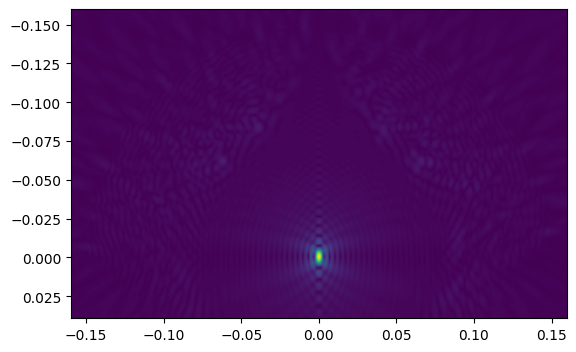

In [147]:
u2=ReadFromH5py('/Users/spichardo/Documents/TestU2Exablate.h5')['u2']
u2=u2.reshape(xx.shape)
u2a=np.abs(u2)
plt.figure()
plt.imshow(u2a[u2a.shape[0]//2,:,:].T,extent=[yl.min(),yl.max(),zl.max(),zl.min()])

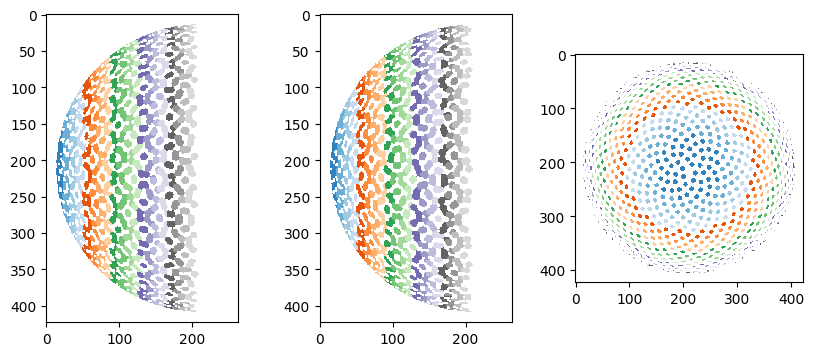

In [149]:
SourceMap=np.zeros(xx.shape,np.uint32)
Qx=np.zeros(xx.shape,np.float32)
Qy=np.zeros(xx.shape,np.float32)
Qz=np.zeros(xx.shape,np.float32)
nBase=0
nBaseVert=0
Orig=[xl[0],yl[0],zl[0]]
for n in range(TxHighRes['NumberElems']):
    SelCenters=TxHighRes['center'][nBase:nBase+TxHighRes['elemdims'],:]
    SelCenters=np.vstack((TxHighRes['center'][nBase:nBase+TxHighRes['elemdims'],:],
                          TxHighRes['VertDisplay'][nBaseVert:nBase+TxHighRes['elemdims']*4,:]))
    
    IndX=np.round((SelCenters[:,0]-Orig[0])/Step).astype(int)
    IndY=np.round((SelCenters[:,1]-Orig[1])/Step).astype(int)
    IndZ=np.round((SelCenters[:,2]-Orig[2])/Step).astype(int)
    assert(np.all(SourceMap[IndX,IndY,IndZ]==0))
    SourceMap[IndX,IndY,IndZ]=n+1
    Directions=-SelCenters/150.0e-3
    Qx[IndX,IndY,IndZ]=Directions[:,0]
    Qy[IndX,IndY,IndZ]=Directions[:,1]
    Qz[IndX,IndY,IndZ]=Directions[:,2]
    nBase+=TxHighRes['elemdims']
    nBaseVert+=TxHighRes['elemdims']*4

plt.close('all')
f,axs=plt.subplots(1,3,figsize=(10,4))
axs=axs.flatten()
for n in range(3):
    proj=np.max(SourceMap,axis=n).astype(float)
    proj[proj==0]=np.nan
    axs[n].imshow(proj,cmap=plt.cm.tab20c)



Domain size 423 423 264
Calculating Relaxation coefficients for  0
 Q unique entries  0
Calculating Relaxation coefficients for  0
 Q unique entries  0
VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
"ideal" TemporalStep 1.2496759073368523e-07
PPP 40.0


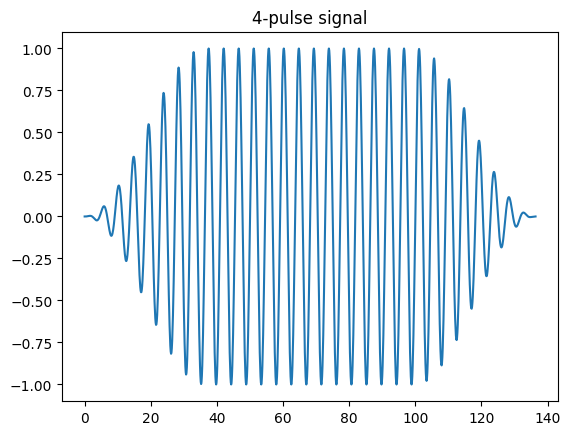

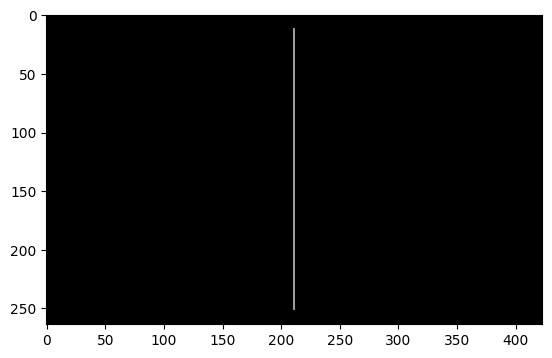

In [150]:
PMLThickness = 12 # grid points for perect matching layer, HIGHLY RECOMMENDED DO NOT CHANGE THIS SIZE 
ReflectionLimit= 1.0000e-05 #reflection parameter for PML, IGHLY RECOMMENDED DO NOT CHANGE THIS VALUE

N1=len(xl)
N2=len(yl)
N3=len(zl)
print('Domain size',N1,N2,N3)
DimDomain=[xl.max()-xl.min(),yl.max()-yl.min(),zl.max()-zl.min()]
MediumSOS=1500.0
MediumDensity=1000.0

MaterialMap=np.zeros((N1,N2,N3),np.uint32) # note the 32 bit size
MaterialList=np.zeros((1,5)) # one material in this examples
MaterialList[0,0]=MediumDensity # water density
MaterialList[0,1]=MediumSOS # water SoS


TemporalStep,_,_, _, _,_,_,_,_,_=PModel.CalculateMatricesForPropagation(MaterialMap,MaterialList,Frequency,1,Step,0.5)

print('"ideal" TemporalStep',TemporalStep)

#now we make it to be an integer division of the period
PPP=np.ceil(1/Frequency/TemporalStep)
#we add to catch the weird case it ends in large prime number, to avoid having a sensor that needs so many points
if PPP==31:
    PPP=32
elif PPP==34:
    PPP=35
elif PPP==23:
    PPP=24
elif PPP==71:
    PPP=72
elif PPP==74:
    PPP=75
elif PPP==79:
    PPP=80
elif PPP==47:
    PPP=48
elif PPP %5 !=0:
    PPP=(PPP//5 +1)*5

print('PPP',PPP)

TemporalStep=1/Frequency/PPP # we make it an integer of the period

TimeSimulation=np.sqrt(DimDomain[0]**2+DimDomain[1]**2+DimDomain[2]**2)/MediumSOS #time to cross one corner to another


LengthSource=30.0/Frequency #we will use 4 pulses
TimeVectorSource=np.arange(0,LengthSource+TemporalStep,TemporalStep)

ramp_length=8
ramp_length_points = int(np.round(ramp_length/Frequency/TemporalStep))
ramp_axis =np.arange(0,np.pi,np.pi/ramp_length_points)

# create ramp using a shifted cosine
ramp = (-np.cos(ramp_axis) + 1) * 0.5
ramp_length_points=len(ramp)

PulseSource = np.sin(2*np.pi*Frequency*TimeVectorSource)
PulseSource[:int(ramp_length_points)]*=ramp
PulseSource[-int(ramp_length_points):]*=np.flip(ramp)

#note we need expressively to arrange the data in a 2D array
PulseSource=np.reshape(PulseSource,(1,len(TimeVectorSource)))
PulseSource=np.repeat(PulseSource,TxHighRes['NumberElems'],axis=0)
SensorMap=np.zeros((N1,N2,N3),np.uint32)
SensorMap[N1//2,N2//2,PMLThickness:-PMLThickness]=1

plt.close('all')

plt.figure()
plt.plot(TimeVectorSource*1e6,PulseSource[0,:])
plt.title('4-pulse signal')

plt.figure()
plt.imshow(SensorMap[:,N2//2,:].T,cmap=plt.cm.gray)

In [151]:
Sensor,LastMap,DictRMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         Step,
                                                         TimeSimulation,
                                                         SensorMap,
                                                        #  Ox=Qx, 
                                                        #  Oy=Qy, 
                                                        #  Oz=Qz, 
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=3,
                                                         USE_SINGLE=True,
                                                         SelRMSorPeak=1, #we select now only peak data
                                                         DT=TemporalStep,
                                                         QfactorCorrection=True,
                                                         SelMapsRMSPeakList=['Pressure'],
                                                         SelMapsSensorsList=['Pressure'],
                                                         DefaultGPUDeviceName='M3',
                                                         TypeSource=2)

Calculating Relaxation coefficients for  0
 Q unique entries  0
Calculating Relaxation coefficients for  0
 Q unique entries  0
VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 1.1363636363636364e-07 2.474358296526968e-07
Matrix size= 423 x 423 x 264 , spatial resolution = 0.000757576, time steps = 2899, temporal step = 1.13636e-07, total sonication length 0.000329383 
Performing Simulation with GPU METAL
Attempting Metal Initiation...
Selecting device:  Apple M3 Max
metalcompute.Device(Apple M3 Max)
Number Selected Sensor Maps: 1
Allocating for V_x_x 9140689 elements
Allocating for V_y_x 9140689 elements
Allocating for V_z_x 9140689 elements
Allocating for V_x_y 9140689 elements
Allocating for V_y_y 9140689 elements
Allocating for V_z_y 9140689 elements
Allocating for V_x_z 9207946 elements
Allocating for V_y_z 9207946 elements
Allocating for

In [152]:
SaveToH5py(DictRMSValue,'/Users/spichardo/Documents/FirstBabelExablate.h5')

Text(0.5, 1.0, 'X axis at Z = -15.30')

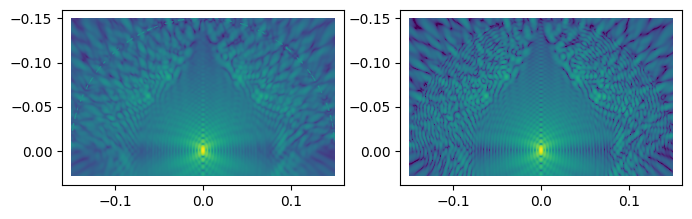

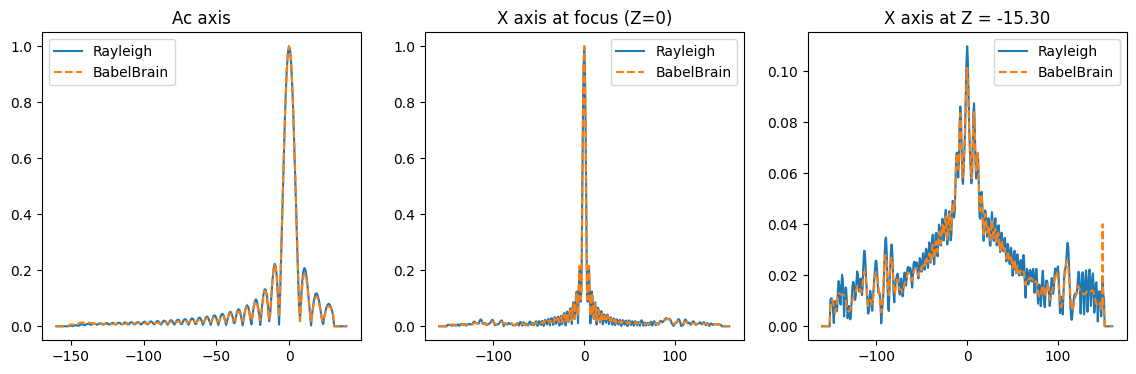

In [168]:
DictRMSValue=ReadFromH5py('/Users/spichardo/Documents/FirstBabelExablate.h5')
plt.close('all')
f,axs=plt.subplots(1,2,figsize=(8,4))
pB=DictRMSValue['Pressure']/DictRMSValue['Pressure'].max()
# pB[pB==0]=np.unique(pB)[1] #next value after 0
u2a/=u2a.max()
u2a[pB==0]=0
with np.errstate(divide='ignore', invalid='ignore'):
    im=axs[0].imshow(20*np.log10(pB[N1//2,:,:].T),vmin=-60,extent=[yl.min(),yl.max(),zl.max(),zl.min()])
    # plt.colorbar(im)
    axs[1].imshow(20*np.log10(u2a[N1//2,:,:].T),vmin=-60,extent=[yl.min(),yl.max(),zl.max(),zl.min()])

f,axs=plt.subplots(1,3,figsize=(14,4))
axs[0].plot(zl*1e3,u2a[N1//2,N2//2,:])
axs[0].plot(zl*1e3,pB[N1//2,N2//2,:],'--')
axs[0].legend(['Rayleigh','BabelBrain'])
axs[0].set_title('Ac axis')

zfloc=np.argmin(np.abs(zl))
axs[1].plot(xl*1e3,u2a[:,N2//2,zfloc])
axs[1].plot(xl*1e3,pB[:,N2//2,zfloc],'--')
axs[1].legend(['Rayleigh','BabelBrain'])
axs[1].set_title('X axis at focus (Z=0)')
axs[2].plot(xl*1e3,u2a[:,N2//2,zfloc-20])
axs[2].plot(xl*1e3,pB[:,N2//2,zfloc-20],'--')
axs[2].legend(['Rayleigh','BabelBrain'])
axs[2].set_title(f'X axis at Z = {zl[zfloc-20]*1e3:0.02f}')


In [184]:
from sklearn import metrics
def CalcVolumetricMetrics(Data,voxelsize):
    DataN=Data/Data.max()
    label_img=label(DataN>=0.5)
    props = regionprops(label_img)#, properties=('centroid',   'area', 'moments_central','axis_major_length','axis_minor_length'))
    Res={}
    if len(props)>1:
        Volumes=[]
        for p in props:
            Volumes.append(p['area'])  
        p=props[np.argmax(Volumes)]
    else:
        p=props[0]
    Res['centroid']=p['centroid']*voxelsize
    Res['volume']=p['area']*np.prod(voxelsize)
    Axes=ellipsoid_axis_lengths(p['moments_central'])
    Res['long_axis']=Axes[0]*voxelsize[0]
    Res['minor_axis_1']=Axes[1]*voxelsize[1]
    Res['minor_axis_2']=Axes[2]*voxelsize[2]
    # print(Res)
    return Res

def ellipsoid_axis_lengths(central_moments):
    """Compute ellipsoid major, intermediate and minor axis length.

    Parameters
    ----------
    central_moments : ndarray
        Array of central moments as given by ``moments_central`` with order 2.

    Returns
    -------
    axis_lengths: tuple of float
        The ellipsoid axis lengths in descending order.
    """
    m0 = central_moments[0, 0, 0]
    sxx = central_moments[2, 0, 0] / m0
    syy = central_moments[0, 2, 0] / m0
    szz = central_moments[0, 0, 2] / m0
    sxy = central_moments[1, 1, 0] / m0
    sxz = central_moments[1, 0, 1] / m0
    syz = central_moments[0, 1, 1] / m0
    S = np.asarray([[sxx, sxy, sxz], [sxy, syy, syz], [sxz, syz, szz]])
    # determine eigenvalues in descending order
    eigvals = np.sort(np.linalg.eigvalsh(S))[::-1]
    return tuple([np.sqrt(20.0 * e) for e in eigvals])    

def qcheck(AData,BData,Step):
    #the layer where the source was placed should not be considered for comparison
    # in cases where the Tx is moved "into" the skin, there will be a few layers with 0 values, 
    # the source is always placed in the first non-zero layer

    voxelsize=np.array([Step,Step,Step])
    VolA=CalcVolumetricMetrics(AData,voxelsize)
    VolB=CalcVolumetricMetrics(BData,voxelsize)

    LocMaxA=np.array(np.where(AData==AData.max())).flatten()*voxelsize
    LocMaxB=np.array(np.where(BData==BData.max())).flatten()*voxelsize

    
    Metrics={}
    Metrics['Distance focal centroid']=np.linalg.norm(VolA['centroid']-VolB['centroid'])
    Metrics['Distance focal max']=np.linalg.norm(LocMaxA-LocMaxB)
    Metrics['Difference amplitude'] = 100 * (AData.max() - BData.max()) / BData.max()
    Metrics['Difference volume'] = 100 * (VolA['volume'] -VolB['volume']) /VolB['volume']
    Metrics['Difference acoustic long axis'] = 100 * (VolA['long_axis'] - VolB['long_axis']) / VolB['long_axis']
    Metrics['Difference acoustic width 1'] = 100 * (VolA['minor_axis_1'] - VolB['minor_axis_1']) / VolB['minor_axis_1']
    Metrics['Difference acoustic width 2'] = 100 * (VolA['minor_axis_2'] - VolB['minor_axis_2']) / VolB['minor_axis_2']
    LInf=100.0 * np.abs(AData[AData>0] - BData[BData>0]) / BData.max()
    Metrics['L Inf']= LInf.max()
    Metrics['L Inf location']=np.array(np.where(LInf==Metrics['L Inf'])).flatten().tolist()
    Metrics['L2']= 100.0 * np.sqrt(np.sum((AData[AData>0] - BData[AData>0])**2) / np.sum(BData[BData>0]**2) )  
    Metrics['RMSE']=np.sqrt(np.mean((AData[AData>0] - BData[BData>0])**2))
    return Metrics

{'Difference acoustic long axis': 1.547982701957771,
 'Difference acoustic width 1': 0.4012696189448536,
 'Difference acoustic width 2': 0.4012696189448536,
 'Difference amplitude': 0.0,
 'Difference volume': 2.1857923497267637,
 'Distance focal centroid': 6.800715137703084e-05,
 'Distance focal max': 0.0,
 'L Inf': 2.9642236,
 'L Inf location': [13630074],
 'L2': 21.787379682064056,
 'RMSE': 0.0040590176}


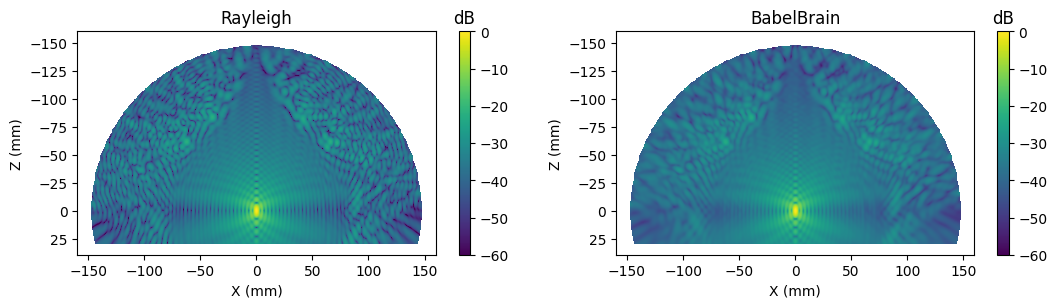

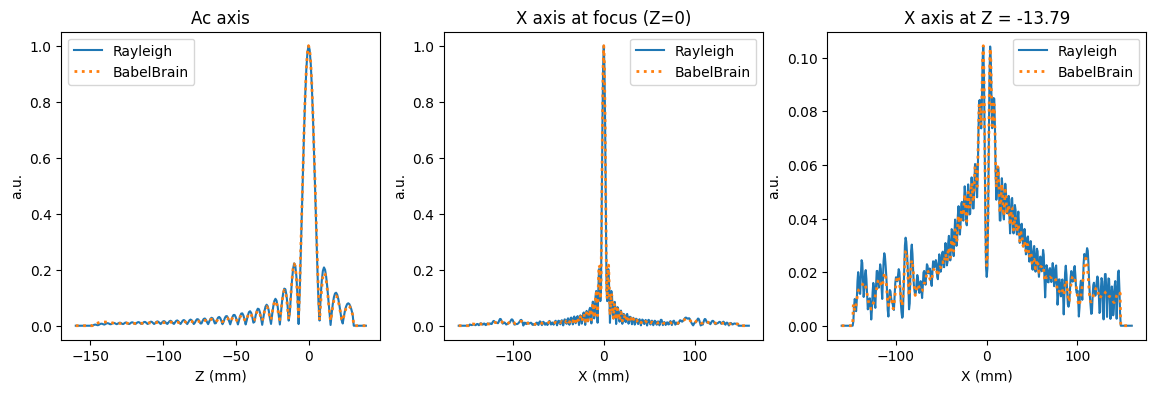

: 

In [ ]:
from pprint import pprint
#we cut out 2 mm from the source
pBred=pB.copy()
u2ared=u2a.copy()
selregion=(xx**2+yy**2+zz**2)>(148e-3)**2
pBred[selregion]=0
u2ared[selregion]=0
u2ared[:,:,-PMLThickness:]=0

plt.close('all')
f,axs=plt.subplots(1,2,figsize=(11,3))
with np.errstate(divide='ignore', invalid='ignore'):
    im=axs[1].imshow(20*np.log10(pBred[N1//2,:,:].T),vmin=-60,extent=[yl.min()*1e3,yl.max()*1e3,zl.max()*1e3,zl.min()*1e3])
    axs[1].set_title('BabelBrain')
    axs[1].set_xlabel('X (mm)')
    axs[1].set_ylabel('Z (mm)')
    plt.colorbar(im).ax.set_title('dB')
    im=axs[0].imshow(20*np.log10(u2ared[N1//2,:,:].T),vmin=-60,extent=[yl.min()*1e3,yl.max()*1e3,zl.max()*1e3,zl.min()*1e3])
    axs[0].set_title('Rayleigh')
    axs[0].set_xlabel('X (mm)')
    axs[0].set_ylabel('Z (mm)')
    plt.colorbar(im).ax.set_title('dB')
plt.tight_layout()
plt.savefig('/Users/spichardo/Library/CloudStorage/OneDrive-UniversityofCalgary/GDrive/Ac Properties KBP/ExablateSims/2DComparisonBabelRayleighExablate.pdf',bbox_inches='tight')

with np.errstate(divide='ignore', invalid='ignore'):
    f,axs=plt.subplots(1,3,figsize=(14,4))
    axs[0].plot(zl*1e3,u2ared[N1//2,N2//2,:])
    axs[0].plot(zl*1e3,pBred[N1//2,N2//2,:],':',linewidth=2)
    axs[0].legend(['Rayleigh','BabelBrain'])
    axs[0].set_title('Ac axis')
    axs[0].set_xlabel('Z (mm)')
    axs[0].set_ylabel('a.u.')
    

    zfloc=np.argmin(np.abs(zl))
    axs[1].plot(xl*1e3,u2ared[:,N2//2,zfloc])
    axs[1].plot(xl*1e3,pBred[:,N2//2,zfloc],':',linewidth=2)
    axs[1].legend(['Rayleigh','BabelBrain'])
    axs[1].set_title('X axis at focus (Z=0)')
    axs[1].set_xlabel('X (mm)')
    axs[1].set_ylabel('a.u.')
    axs[2].plot(xl*1e3,u2ared[:,N2//2,zfloc-PPW*2])
    axs[2].plot(xl*1e3,pBred[:,N2//2,zfloc-PPW*2],':',linewidth=2)
    axs[2].legend(['Rayleigh','BabelBrain'])
    axs[2].set_title(f'X axis at Z = {zl[zfloc-PPW*2]*1e3:0.02f}')
    axs[2].set_xlabel('X (mm)')
    axs[2].set_ylabel('a.u.')
f.savefig('/Users/spichardo/Library/CloudStorage/OneDrive-UniversityofCalgary/GDrive/Ac Properties KBP/ExablateSims/AxesComparisonBabelRayleigh.pdf',bbox_inches='tight')

metrics=qcheck(pBred,u2ared,Step)
pprint(metrics)

In [189]:
Step*1e3

0.7575757575757576

In [54]:
from scipy import ndimage

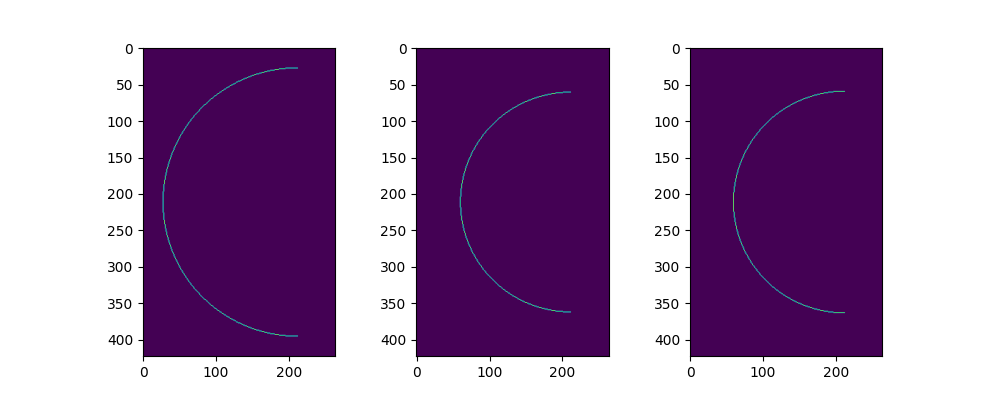

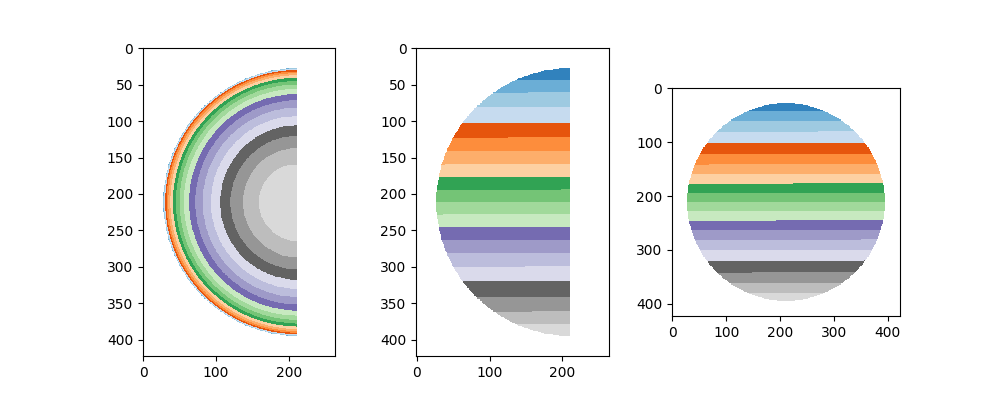

In [124]:
SourceMap=np.zeros(xx.shape,np.uint32)
Qx=np.zeros(xx.shape,np.float32)
Qy=np.zeros(xx.shape,np.float32)
Qz=np.zeros(xx.shape,np.float32)
zfloc=np.argmin(np.abs(zl))
center=(N1//2,N2//2,zfloc)
dist = np.sqrt((ii-center[0])**2 + (jj-center[1])**2 + (kk-center[2])**2)
mask = ((xx**2+yy**2+zz**2)<140e-3**2)
mask=np.logical_xor(mask,ndimage.binary_erosion(mask))
mask[zz>=0]=False
si,sj,sk=np.where(mask)


plt.close('all')
f,axs=plt.subplots(1,3,figsize=(10,4))
axs=axs.flatten()
axs[0].imshow(mask[N1//2,:,:])
axs[1].imshow(mask[N1//4,:,:])
axs[2].imshow(mask[N1//4*3,:,:])


PulseSource = np.zeros((len(si),len(TimeVectorSource)))

l=0
for i,j,k in zip(si,sj,sk):
    SourceMap[i,j,k]=l+1
    indPulse=np.sin(2*np.pi*Frequency*TimeVectorSource+np.angle(u2[i,j,k]))
    indPulse[:int(ramp_length_points)]*=ramp
    indPulse[-int(ramp_length_points):]*=np.flip(ramp)
    PulseSource[l,:]=indPulse
    Direction=-np.array([xx[i,j,k],yy[i,j,k],zz[i,j,k]])
    Direction/=np.sqrt(np.sum(Direction**2))
    Qx[i,j,k]=Direction[0]
    Qy[i,j,k]=Direction[1]
    Qz[i,j,k]=Direction[2]
    l+=1

f,axs=plt.subplots(1,3,figsize=(10,4))
axs=axs.flatten()



for n in range(3):
    proj=np.max(SourceMap,axis=n).astype(float)
    proj[proj==0]=np.nan
    axs[n].imshow(proj,cmap=plt.cm.tab20c)


In [127]:
Sensor,LastMap,DictRMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         Step,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         Ox=Qx, 
                                                         Oy=Qy, 
                                                         Oz=Qz, 
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=3,
                                                         USE_SINGLE=True,
                                                         SelRMSorPeak=1, #we select now only peak data
                                                         DT=TemporalStep,
                                                         QfactorCorrection=True,
                                                         SelMapsRMSPeakList=['Pressure'],
                                                         SelMapsSensorsList=['Pressure'],
                                                         DefaultGPUDeviceName='M3',
                                                         TypeSource=0)

Calculating Relaxation coefficients for  0
 Q unique entries  0
Calculating Relaxation coefficients for  0
 Q unique entries  0
VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 1.1363636363636364e-07 2.474358296526968e-07
Matrix size= 423 x 423 x 264 , spatial resolution = 0.000757576, time steps = 2899, temporal step = 1.13636e-07, total sonication length 0.000329383 
Performing Simulation with GPU METAL
Attempting Metal Initiation...
Selecting device:  Apple M3 Max
metalcompute.Device(Apple M3 Max)
Number Selected Sensor Maps: 1
Allocating for V_x_x 9140689 elements
Allocating for V_y_x 9140689 elements
Allocating for V_z_x 9140689 elements
Allocating for V_x_y 9140689 elements
Allocating for V_y_y 9140689 elements
Allocating for V_z_y 9140689 elements
Allocating for V_x_z 9207946 elements
Allocating for V_y_z 9207946 elements
Allocating for

In [128]:
SaveToH5py(DictRMSValue,'/Users/spichardo/Documents/SecondBabelExablate.h5')

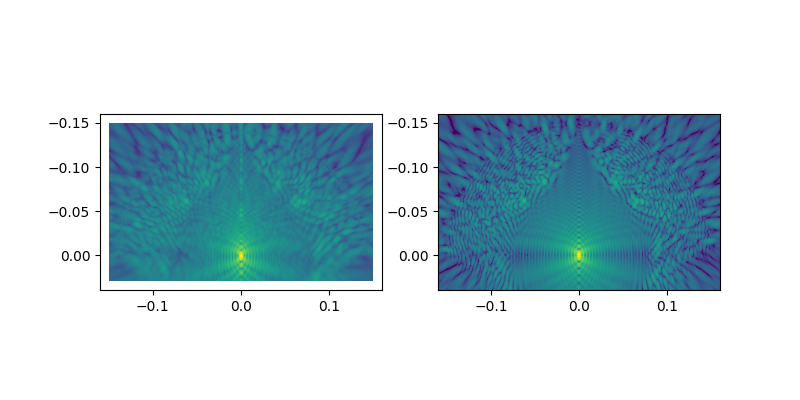

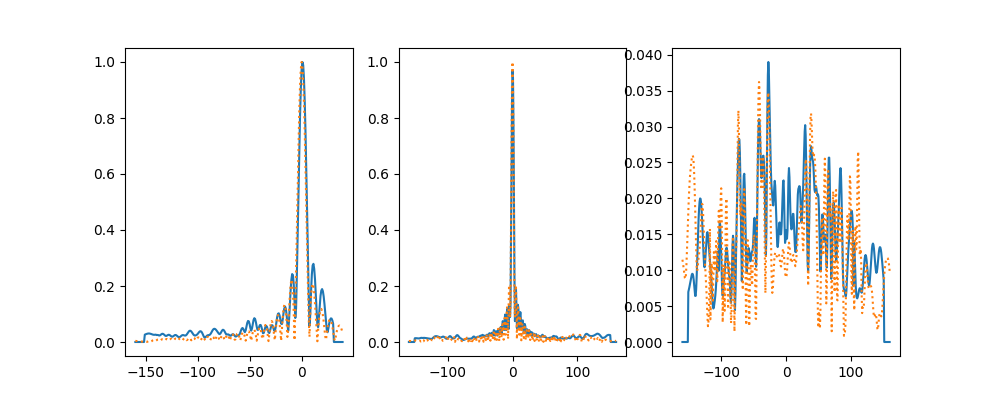

In [129]:
plt.close('all')
f,axs=plt.subplots(1,2,figsize=(8,4))
pB=DictRMSValue['Pressure']/DictRMSValue['Pressure'].max()
# pB[pB==0]=np.unique(pB)[1] #next value after 0
u2a/=u2a.max()
with np.errstate(divide='ignore', invalid='ignore'):
    im=axs[0].imshow(20*np.log10(pB[N1//2,:,:].T),vmin=-60,extent=[yl.min(),yl.max(),zl.max(),zl.min()])
    # plt.colorbar(im)
axs[1].imshow(20*np.log10(u2a[N1//2,:,:].T),vmin=-60,extent=[yl.min(),yl.max(),zl.max(),zl.min()])

f,axs=plt.subplots(1,3,figsize=(10,4))
axs[0].plot(zl*1e3,pB[N1//2,N2//2,:])
axs[0].plot(zl*1e3,u2a[N1//2,N2//2,:],':')

zfloc=np.argmin(np.abs(zl))
axs[1].plot(xl*1e3,pB[:,N2//2,zfloc])
axs[1].plot(xl*1e3,u2a[:,N2//2,zfloc],':')
axs[2].plot(xl*1e3,pB[:,N2//2,N3//3])
axs[2].plot(xl*1e3,u2a[:,N2//2,N3//3],':')

{'Distance focal centroid': 0.0007595191457215767,
 'Distance focal max': 0.0007575757575757625,
 'Difference amplitude': 0.0,
 'Difference volume': 8.196721311475397,
 'Difference acoustic long axis': -2.1820537571530094,
 'Difference acoustic width 1': 9.100228285359336,
 'Difference acoustic width 2': 2.94423985133483,
 'L Inf': 17.272642,
 'L Inf location': [211, 211, 206],
 'L2': 37.550657987594604,
 'RMSE': 0.006995743}

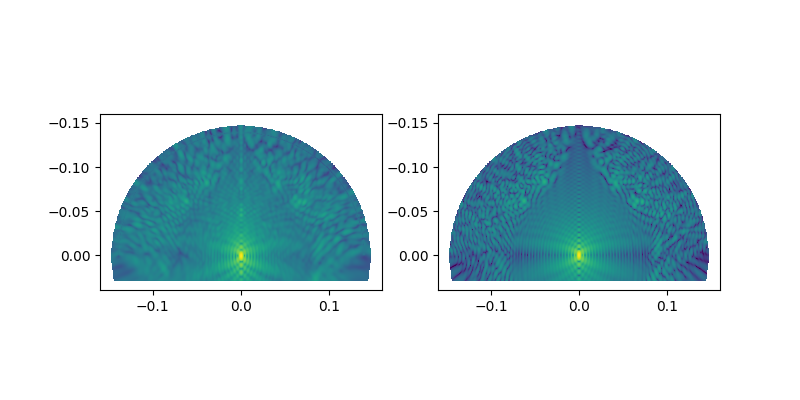

In [130]:
#we cut out 2 mm from the source
pBred=pB.copy()
u2ared=u2a.copy()
selregion=(xx**2+yy**2+zz**2)>(148e-3)**2
pBred[selregion]=0
u2ared[selregion]=0
u2ared[:,:,-PMLThickness:]=0

plt.close('all')
f,axs=plt.subplots(1,2,figsize=(8,4))
with np.errstate(divide='ignore', invalid='ignore'):
    im=axs[0].imshow(20*np.log10(pBred[N1//2,:,:].T),vmin=-60,extent=[yl.min(),yl.max(),zl.max(),zl.min()])
    # plt.colorbar(im)
    axs[1].imshow(20*np.log10(u2ared[N1//2,:,:].T),vmin=-60,extent=[yl.min(),yl.max(),zl.max(),zl.min()])

qcheck(pBred,u2ared,Step)